In [3]:
# Helper imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# DML、DRL、Tree based Models

## Get Data

In [235]:
import pandas as pd
df = pd.read_csv('data/causal_test_data.csv')

In [239]:
print(df[['Y','T','W1','W2','W3','X1','X2','IV1','IV2']].describe())

                 Y            T           W1           W2           W3  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      2.376374     0.541000     0.498200     0.987600     0.023218   
std       1.770173     0.498366     0.500047     0.816811     1.004113   
min      -2.371548     0.000000     0.000000     0.000000    -3.403990   
25%       1.084852     0.000000     0.000000     0.000000    -0.654536   
50%       2.200946     1.000000     0.000000     1.000000     0.034311   
75%       3.512096     1.000000     1.000000     2.000000     0.684923   
max       9.862137     1.000000     1.000000     2.000000     3.886301   

                X1           X2          IV1          IV2  
count  5000.000000  5000.000000  5000.000000  5000.000000  
mean      0.994000    -0.010051     0.506400     0.002017  
std       0.809256     1.007270     0.500009     1.003394  
min       0.000000    -3.697959     0.000000    -3.841058  
25%       0.000000    -0.696655  

In [240]:
df.dtypes

Unnamed: 0      int64
U             float64
IV1             int64
IV2           float64
X1              int64
X2            float64
W1              int64
W2              int64
W3            float64
T               int64
true_HTE      float64
HTE           float64
Y             float64
dtype: object

In [173]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, train_size=0.6, test_size=0.4)
Y = train['Y']
T = train['T']
X = train[['X1','X2','W1','W2','W3']]
Z = train[['IV1','IV2']]

X_test = test[['X1','X2','W1','W2','W3']]

## Base Models

In [162]:
from econml.sklearn_extensions.model_selection import GridSearchCVList
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.base import clone
from econml.sklearn_extensions.linear_model import WeightedLasso

def first_stage_reg():
    return GridSearchCVList([Lasso(),
                             RandomForestRegressor(n_estimators=100, random_state=123),
                             GradientBoostingRegressor(random_state=123)],
                             param_grid_list=[{'alpha': [.001, .01, .1, 1, 10]},
                                               {'max_depth': [3, None],
                                               'min_samples_leaf': [10, 50]},
                                              {'n_estimators': [50, 100],
                                               'max_depth': [3],
                                               'min_samples_leaf': [10, 30]}],
                             cv=5,
                             scoring='neg_mean_squared_error')

def first_stage_clf():
    return GridSearchCVList([LogisticRegression(),
                             RandomForestClassifier(n_estimators=100, random_state=123),
                             GradientBoostingClassifier(random_state=123)],
                             param_grid_list=[{'C': [0.01, .1, 1, 10, 100]},
                                              {'max_depth': [3, 5],
                                               'min_samples_leaf': [10, 50]},
                                              {'n_estimators': [50, 100],
                                               'max_depth': [3],
                                               'min_samples_leaf': [10, 30]}],
                             cv=5,
                             scoring='neg_mean_squared_error')

def final_stage():
    return GridSearchCVList([WeightedLasso(),
                             RandomForestRegressor(n_estimators=100, random_state=123)],
                             param_grid_list=[{'alpha': [.001, .01, .1, 1, 10]},
                                              {'max_depth': [3, 5],
                                               'min_samples_leaf': [10, 50]}],
                             cv=5,
                             scoring='neg_mean_squared_error')

In [80]:
model_y = clone(first_stage_reg().fit(X, Y).best_estimator_)
model_y

GradientBoostingRegressor(min_samples_leaf=10, random_state=123)

In [81]:
model_t = clone(first_stage_clf().fit(X, T).best_estimator_)
model_t

GradientBoostingClassifier(min_samples_leaf=30, n_estimators=50,
                           random_state=123)

## DML Models

In [174]:
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier

n_samples, n_features = X.shape
subsample_fr_ = (n_samples/2)**(1-1/(2*n_features+2))/(n_samples/2)
est = CausalForestDML(model_y=model_y,
                      model_t=model_t,
                      discrete_treatment=True,
                      cv=3,
                      n_estimators=4000,
                      random_state=123)
est.tune(Y, T, X=X).fit(Y, T, X=X, cache_values=True)

In [175]:
from econml.dml import NonParamDML
est2 = NonParamDML(model_y=model_y,
                   model_t=model_t,
                   cv=3,
                   discrete_treatment=True,
                   model_final=final_stage())
est2.fit(Y, T, X=X)

In [176]:
# CausalForestDML的预测结果
pred = est.effect(X_test)
# lb, ub = est.effect_interval(X, alpha=0.05)

In [177]:
# non param DML 的预测结果
pred2 = est2.effect(X_test)

In [178]:
df_res = test.copy(deep=True)
df_res['forestdml'] = pred
df_res['nonparamdml'] = pred2

<AxesSubplot:xlabel='X1'>

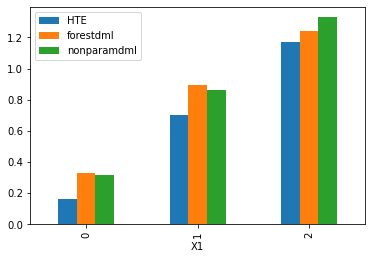

In [179]:
tmp = df_res.copy(deep=True)
tmp = tmp.groupby('X1').mean()
tmp.reset_index(inplace=True)
tmp.plot(x='X1',y=['HTE','forestdml','nonparamdml'], kind='bar')

<AxesSubplot:xlabel='W1'>

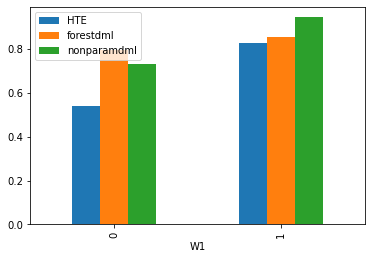

In [180]:
tmp = df_res.copy(deep=True)
tmp = tmp.groupby('W1').mean()
tmp.reset_index(inplace=True)
tmp.plot(x='W1',y=['HTE','forestdml','nonparamdml'], kind='bar')

<AxesSubplot:xlabel='W3'>

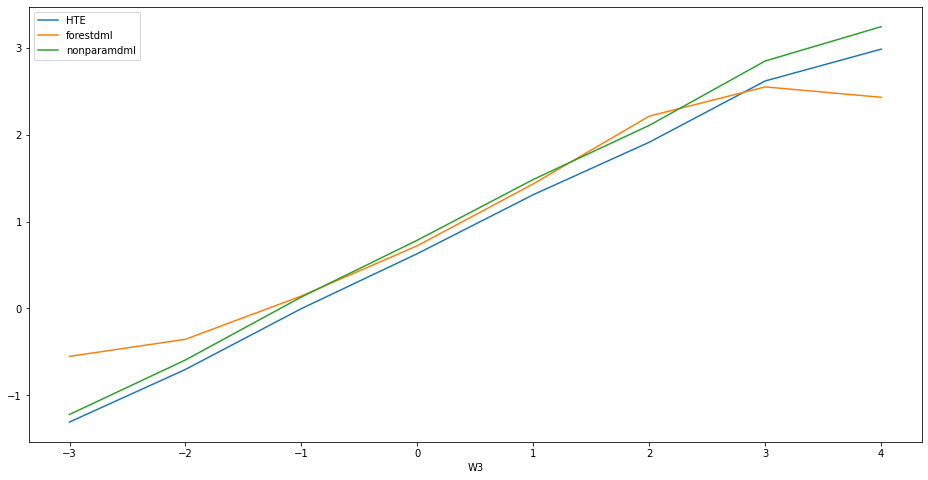

In [181]:
tmp = df_res.copy(deep=True)
tmp['W3'] = tmp['W3'].apply(lambda x : round(x,0))
tmp = tmp.groupby('W3').mean()
tmp.reset_index(inplace=True)
tmp.sort_values('W3').plot(x='W3',y=['HTE','forestdml','nonparamdml'], kind='line',figsize=(16,8))

## DRL Models

In [182]:
# DRL:利用T、X的信息估计Y
model_regression = clone(first_stage_reg().fit(np.hstack([T.values.reshape(-1, 1), X]), Y).best_estimator_)
model_regression

GradientBoostingRegressor(min_samples_leaf=10, random_state=123)

In [183]:
from econml.dr import ForestDRLearner
from sklearn.dummy import DummyRegressor, DummyClassifier

est = ForestDRLearner(model_regression=model_y,
                      model_propensity=model_t,
                      cv=3,
                      n_estimators=4000,
                      min_samples_leaf=10,
                      verbose=0,
                      min_weight_fraction_leaf=.005)
est.fit(Y, T, X=X)

In [184]:
from econml.dr import DRLearner
est2 = DRLearner(model_regression=model_y,
                 model_propensity=model_t,
                 model_final=final_stage(),
                 cv=3)
est2.fit(Y, T.values.reshape((-1, 1)), X=X)

In [185]:
pred = est.effect(X_test)
pred2 = est2.effect(X_test)

In [186]:
df_res['forestdrl'] = pred
df_res['nonparamdrl'] = pred2

<AxesSubplot:xlabel='X1'>

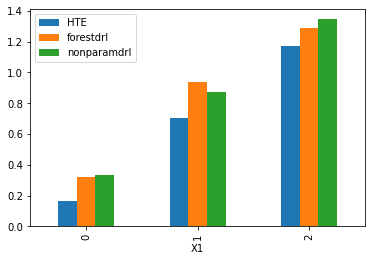

In [187]:
tmp = df_res.copy(deep=True)
tmp = tmp.groupby('X1').mean()
tmp.reset_index(inplace=True)
tmp.plot(x='X1',y=['HTE','forestdrl','nonparamdrl'], kind='bar')

<AxesSubplot:xlabel='W1'>

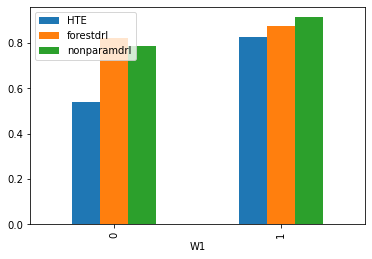

In [188]:
tmp = df_res.copy(deep=True)
tmp = tmp.groupby('W1').mean()
tmp.reset_index(inplace=True)
tmp.plot(x='W1',y=['HTE','forestdrl','nonparamdrl'], kind='bar')

<AxesSubplot:xlabel='W3'>

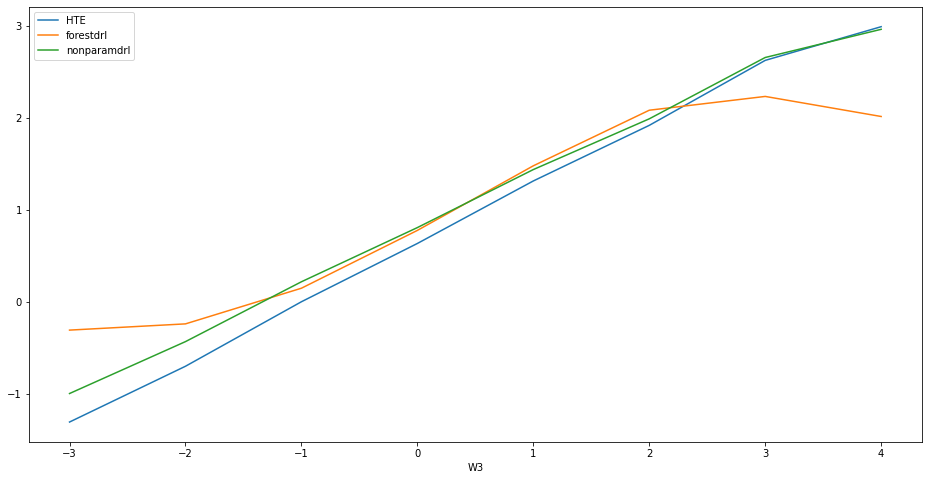

In [189]:
tmp = df_res.copy(deep=True)
tmp['W3'] = tmp['W3'].apply(lambda x : round(x,0))
tmp = tmp.groupby('W3').mean()
tmp.reset_index(inplace=True)
tmp.sort_values('W3').plot(x='W3',y=['HTE','forestdrl','nonparamdrl'], kind='line',figsize=(16,8))

## DROrthoForest -Failed

In [190]:
# from econml.orf import DROrthoForest
# from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
# from econml.sklearn_extensions.linear_model import WeightedLassoCV

# est3 = DROrthoForest(model_Y=Lasso(alpha=0.01),
#                      propensity_model=LogisticRegression(C=1),
#                      model_Y_final=WeightedLassoCV(cv=3),
#                      propensity_model_final=LogisticRegressionCV(cv=3),
#                      n_trees=1000, min_leaf_size=10)
# est3.fit(Y, T, X=X)
# pred3 = est3.effect(X)

## GRF

In [191]:
from econml.grf import CausalForest
est = CausalForest(criterion='het', n_estimators=400, min_samples_leaf=5, max_depth=None,
                   min_var_fraction_leaf=None, min_var_leaf_on_val=True,
                   min_impurity_decrease = 0.0, max_samples=0.45, min_balancedness_tol=.45,
                   warm_start=False, inference=True, fit_intercept=True, subforest_size=4,
                   honest=True, verbose=0, n_jobs=-1, random_state=1235)
est.fit(X, T, Y)
est_grf = est.predict(X_test)

df_res['grf'] = est_grf

## Summary of results

In [192]:
df_summary = df_res.copy(deep = True)

<AxesSubplot:xlabel='X1'>

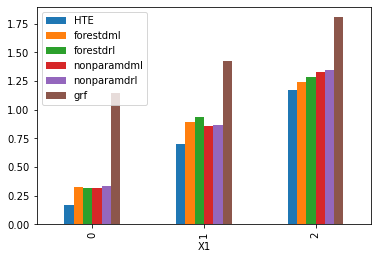

In [193]:
tmp = df_summary.copy(deep=True)
tmp = tmp.groupby('X1').mean()
tmp.reset_index(inplace=True)
tmp.plot(x='X1',y=['HTE','forestdml','forestdrl','nonparamdml','nonparamdrl','grf'], kind='bar')

<AxesSubplot:xlabel='W1'>

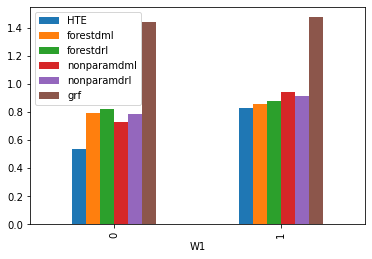

In [194]:
tmp = df_summary.copy(deep=True)
tmp = tmp.groupby('W1').mean()
tmp.reset_index(inplace=True)
tmp.plot(x='W1',y=['HTE','forestdml','forestdrl','nonparamdml','nonparamdrl','grf'], kind='bar')

<AxesSubplot:xlabel='W3'>

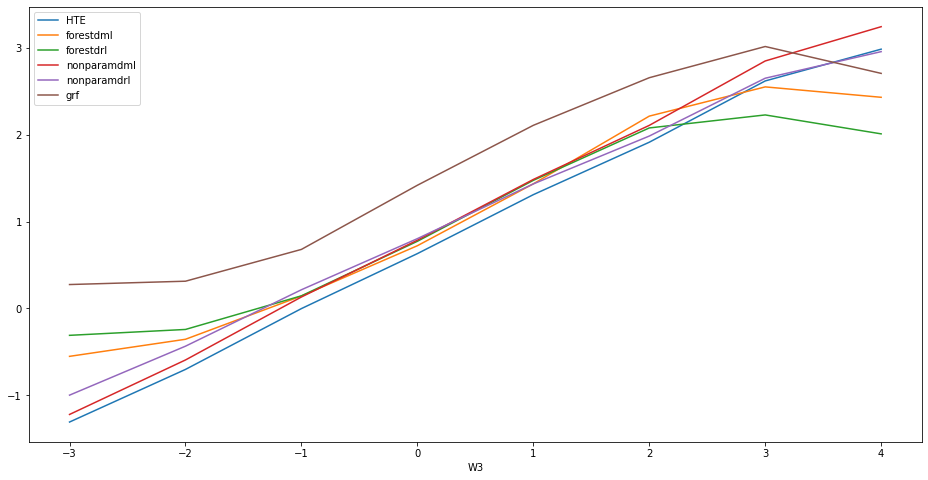

In [195]:
tmp = df_summary.copy(deep=True)
tmp['W3'] = tmp['W3'].apply(lambda x : round(x,0))
tmp = tmp.groupby('W3').mean()
tmp.reset_index(inplace=True)
tmp.sort_values('W3').plot(x='W3',y=['HTE','forestdml','forestdrl','nonparamdml','nonparamdrl','grf'], kind='line',figsize=(16,8))

# meta-Learners

In [196]:
# Main imports
from econml.metalearners import TLearner, SLearner, XLearner, DomainAdaptationLearner

# Helper imports 
import numpy as np
from numpy.random import binomial, multivariate_normal, normal, uniform
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt

%matplotlib inline

## Get Data

In [197]:
n = train.shape[0]

## Train Models

In [198]:
# Instantiate T learner
models = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
T_learner = TLearner(models=models)
# Train T_learner
T_learner.fit(Y, T, X=X)
# Estimate treatment effects on test data
T_te = T_learner.effect(X_test)

In [199]:
# Instantiate S learner
overall_model = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
S_learner = SLearner(overall_model=overall_model)
# Train S_learner
S_learner.fit(Y, T, X=X)
# Estimate treatment effects on test data
S_te = S_learner.effect(X_test)

In [200]:
# Instantiate X learner
models = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
propensity_model = RandomForestClassifier(n_estimators=100, max_depth=6, 
                                                  min_samples_leaf=int(n/100))
X_learner = XLearner(models=models, propensity_model=propensity_model)
# Train X_learner
X_learner.fit(Y, T, X=X)
# Estimate treatment effects on test data
X_te = X_learner.effect(X_test)

## Results Comparation

In [201]:
df_res[['T-learner','S-learner','X-learner']] = np.stack([T_te, S_te, X_te],axis=1)

<AxesSubplot:xlabel='X1'>

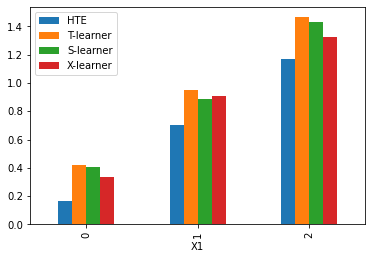

In [202]:
tmp = df_res.copy(deep=True)
tmp = tmp.groupby('X1').mean()
tmp.reset_index(inplace=True)
tmp.plot(x='X1',y=['HTE','T-learner','S-learner','X-learner'], kind='bar')

<AxesSubplot:xlabel='W1'>

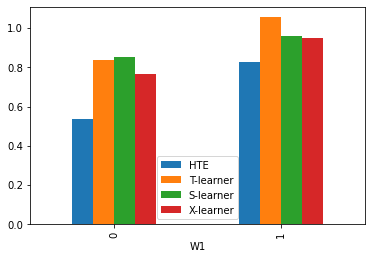

In [203]:
tmp = df_res.copy(deep=True)
tmp = tmp.groupby('W1').mean()
tmp.reset_index(inplace=True)
tmp.plot(x='W1',y=['HTE','T-learner','S-learner','X-learner'], kind='bar')

<AxesSubplot:xlabel='W3'>

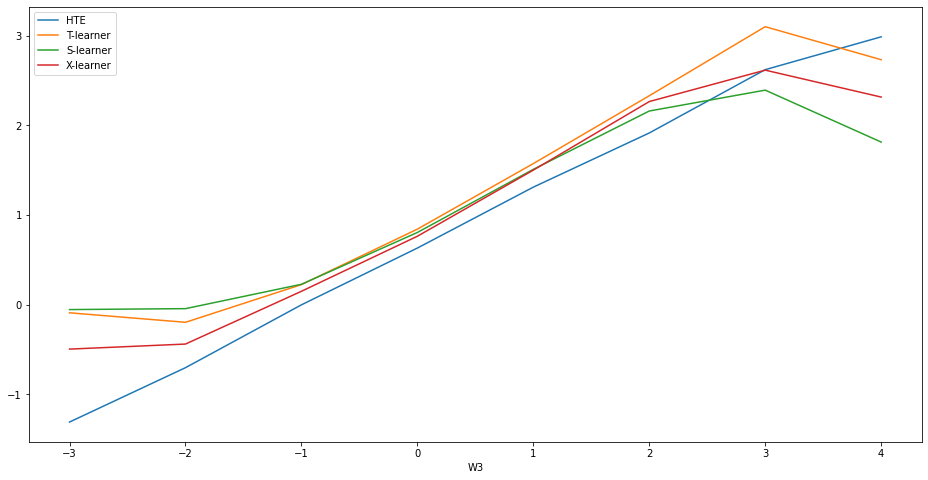

In [204]:
tmp = df_res.copy(deep=True)
tmp['W3'] = tmp['W3'].apply(lambda x : round(x,0))
tmp = tmp.groupby('W3').mean()
tmp.reset_index(inplace=True)
tmp.sort_values('W3').plot(x='W3',y=['HTE','T-learner','S-learner','X-learner'], kind='line',figsize=(16,8))

# Summary of Above Models

In [232]:
y_list = ['HTE','forestdml','forestdrl','grf','nonparamdml','nonparamdrl','T-learner','S-learner','X-learner']
df_summary = df_res.copy(deep=True)

## Comparation of HTE

In [245]:
import numpy as np	# 加载数学库用于函数描述
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style

matplotlib.rcParams['text.usetex'] = False # 开启Latex风格
plt.figure(figsize=(150, 200), dpi=140)  # 设置图像大小
style.use('ggplot')  # 加载'ggplot'风格
# f, ax = plt.subplots(2, 3)  # 设置子图

<Figure size 21000x28000 with 0 Axes>

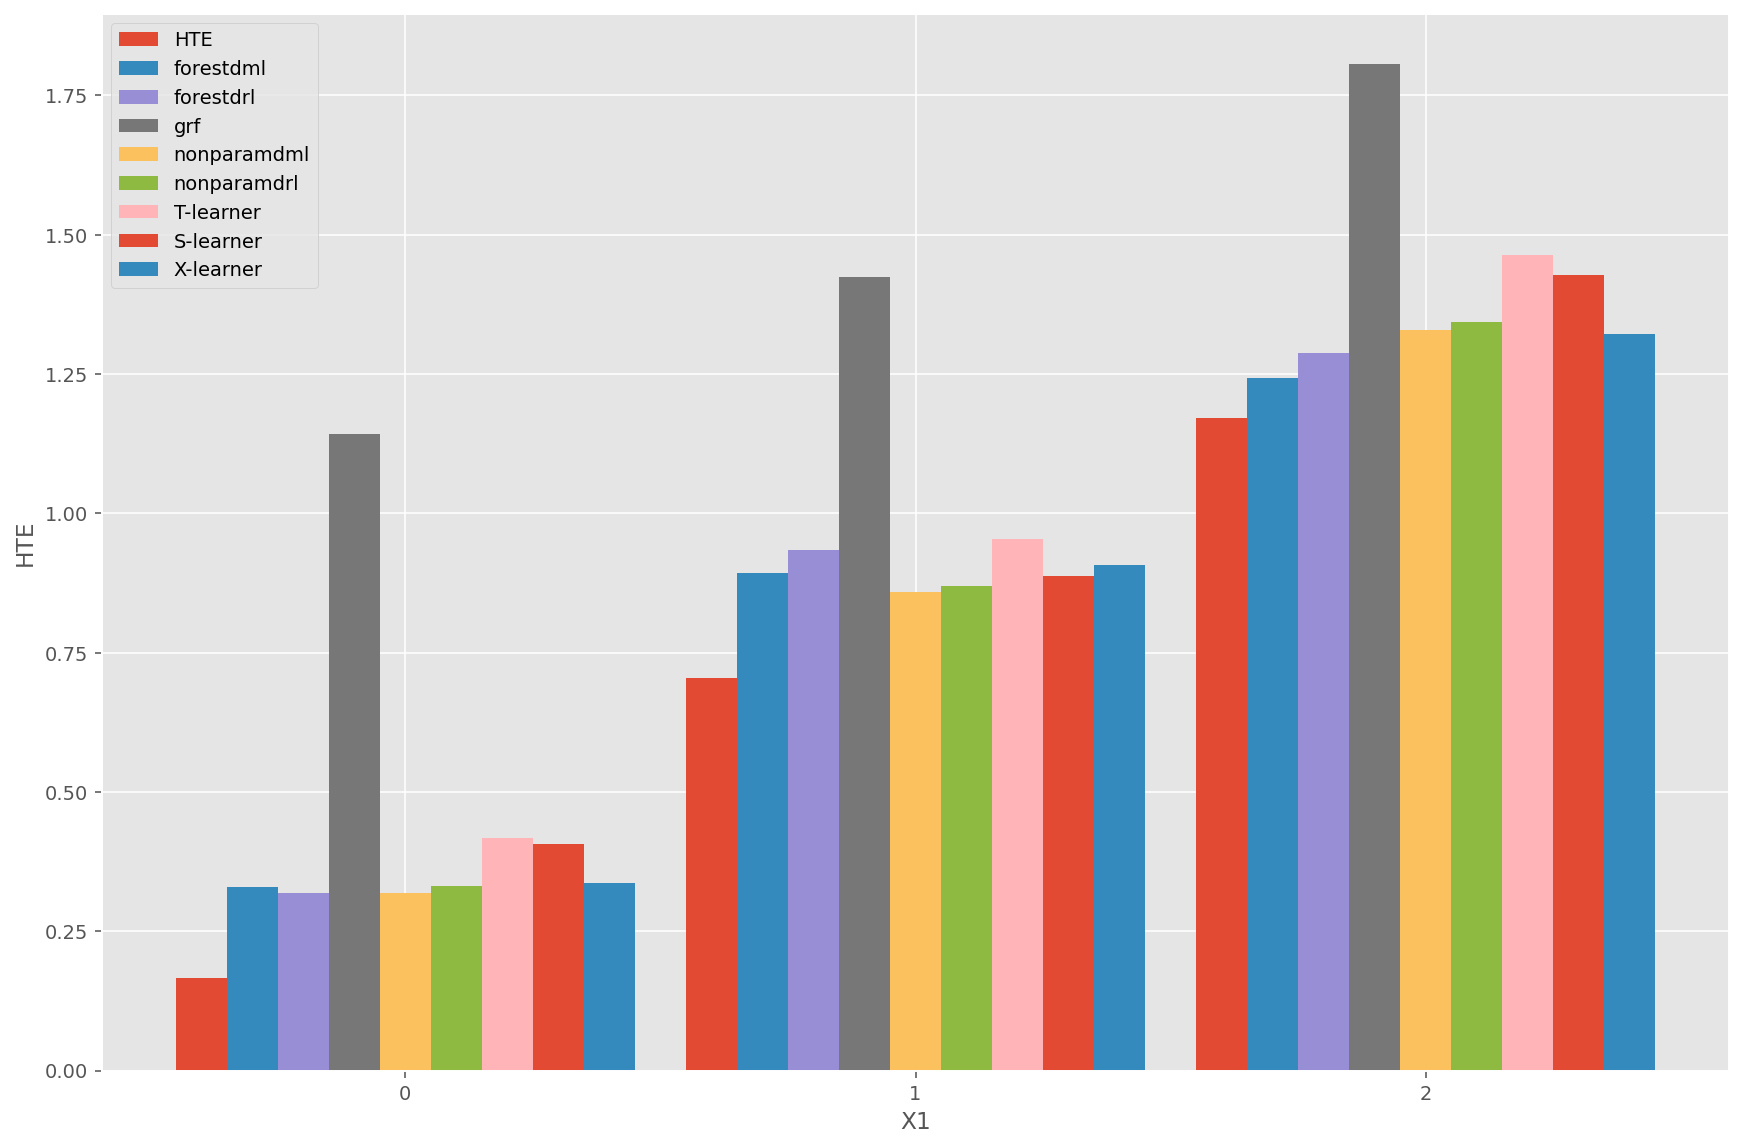

In [247]:
plt.figure(figsize=(15, 10), dpi=140)
tmp = df_summary.copy(deep=True)
tmp = tmp.groupby('X1').mean()
tmp.reset_index(inplace=True)
i = -1
for col in y_list:
    i +=0.2
    plt.bar(tmp['X1']+i/2,tmp[col],label=col,width=0.1)
plt.legend(loc='upper left')
plt.xticks([0,1,2])
plt.xlabel('X1')
plt.ylabel('HTE')
plt.show()
# tmp.plot(x='X1',y=y_list, kind='bar',figsize=(16,8))

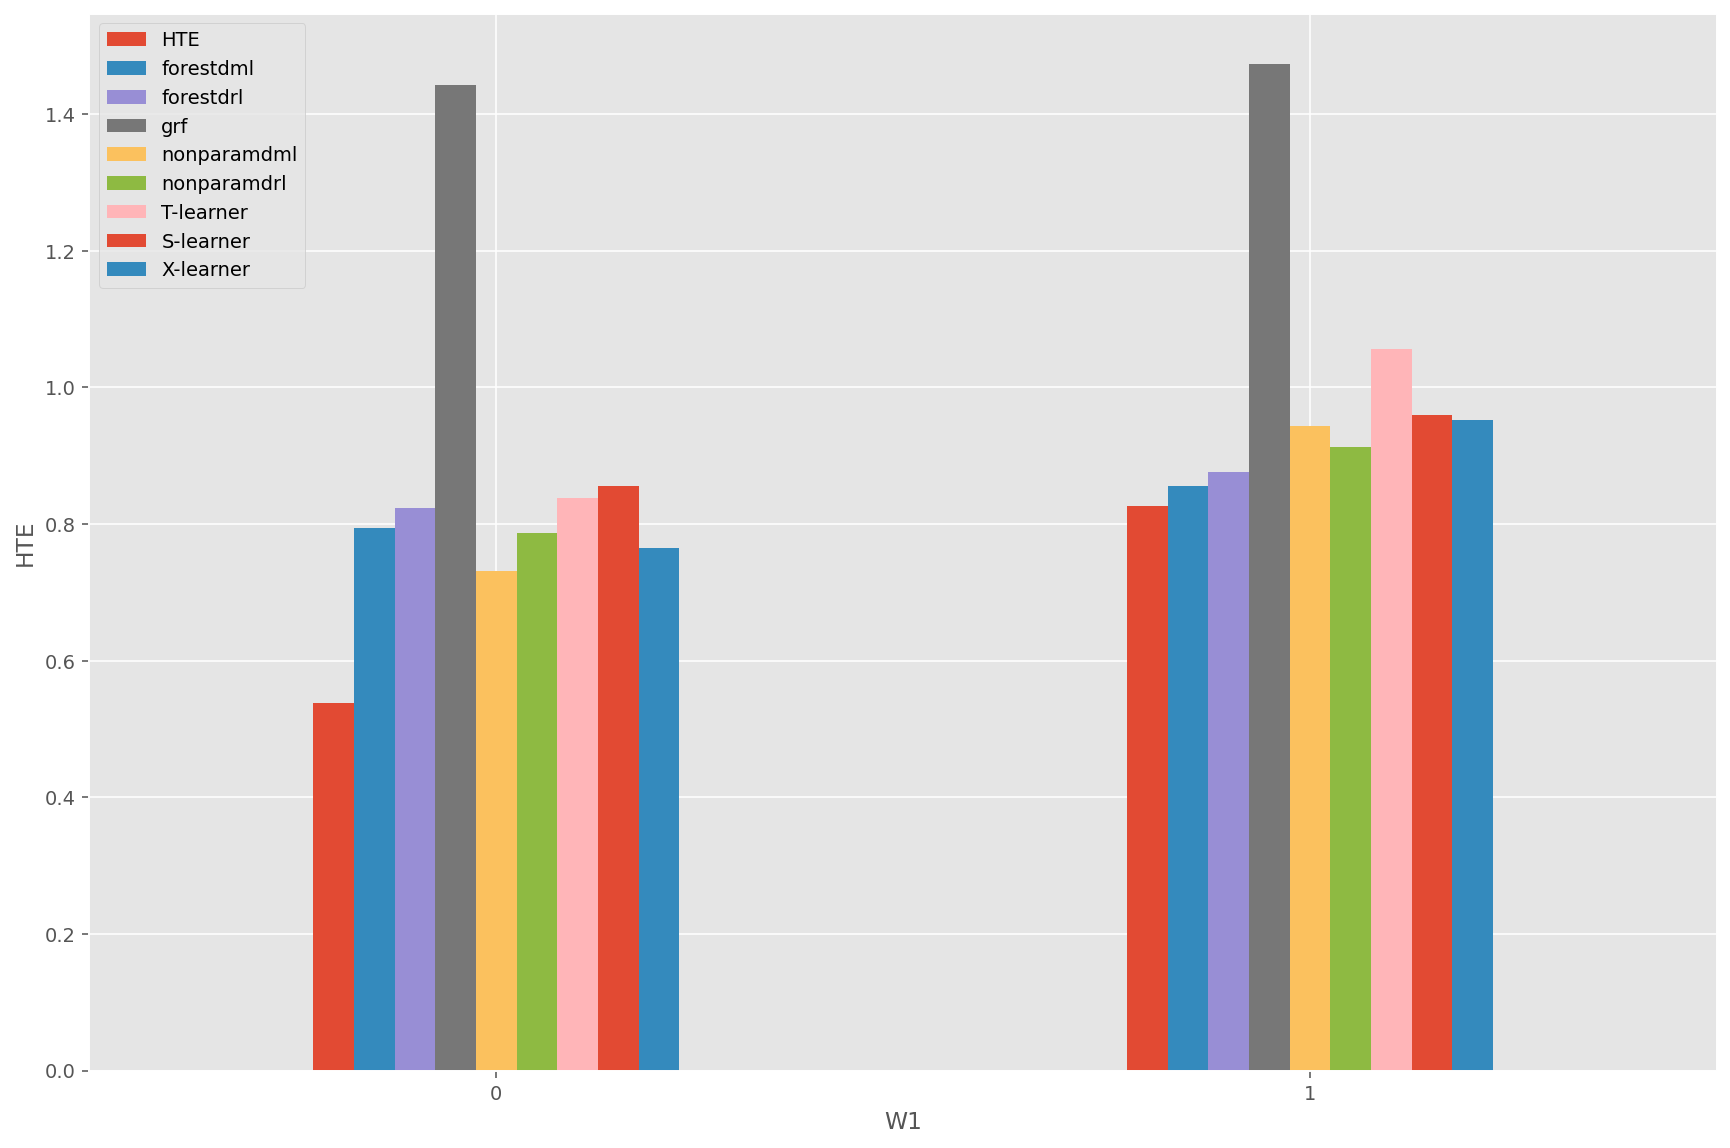

In [251]:
plt.figure(figsize=(15, 10), dpi=140)
tmp = df_summary.copy(deep=True)
tmp = tmp.groupby('W1').mean()
tmp.reset_index(inplace=True)
i = -1
for col in y_list:
    i +=0.2
    plt.bar(tmp['W1']+i/4,tmp[col],label=col,width=0.05)
plt.legend(loc='upper left')
plt.xlim(-0.5,1.5)
plt.xticks([0,1])
plt.xlabel('W1')
plt.ylabel('HTE')
plt.show()
# tmp.plot(x='X1',y=y_list, kind='bar',figsize=(16,8))

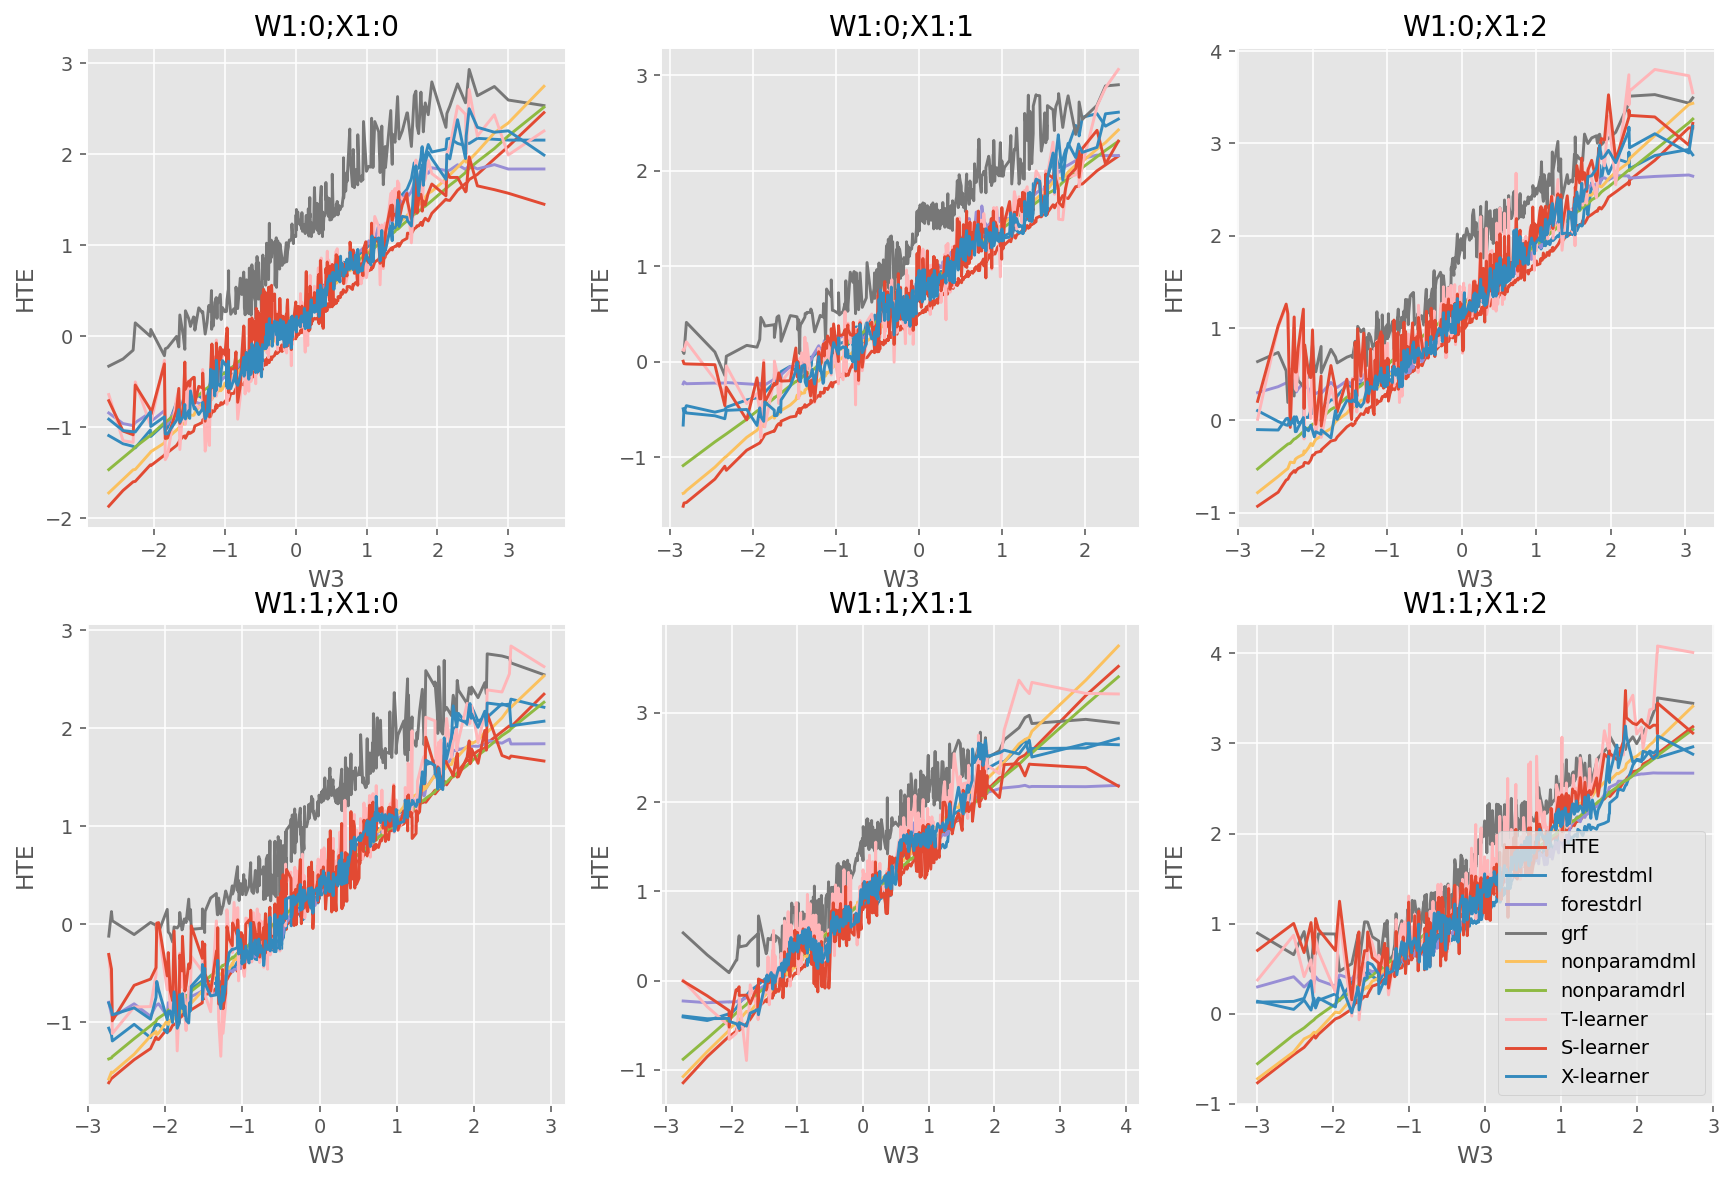

In [250]:
plt.figure(figsize=(15, 10), dpi=140)
i = 0
for w in [0,1]:
    for x in [0,1,2]:
        i += 1
        tmp = df_summary[(df_summary['W1'] == w)&(df_summary['X1'] == x)].copy(deep=True)
        tmp = tmp.sort_values('W3')
        for col in y_list:
            ax = plt.subplot(2, 3, i)
            ax.plot(tmp['W3'], tmp[col], label=col)
            if i == 6:
                plt.legend(loc='lower right')
            plt.title('W1:%d;X1:%d' % (w,x))
            plt.xlabel('W3')
            plt.ylabel('HTE')
plt.show()

## Comparation with Scores

In [209]:
# MSE, MAE, R2, RMSE
import numpy as np
from sklearn.metrics import mean_squared_error #MSE
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import r2_score#R 2
#调用
# mean_squared_error(y_test,y_predict)
# mean_absolute_error(y_test,y_predict)
# np.sqrt(mean_squared_error(y_test,y_predict))  # RMSE就是对MSE开方即可
# r2_score(y_test,y_predict)

In [210]:
score_df = pd.DataFrame({'model':[],'MSE':[],'MAE':[],'R2':[],'RMSE':[]})
for col in y_list:
    if col == 'HTE': continue
    mse = mean_squared_error(y_true=df_res['HTE'], y_pred=df_res[col])
    mae = mean_absolute_error(y_true=df_res['HTE'], y_pred=df_res[col])
    r2 = r2_score(y_true=df_res['HTE'], y_pred=df_res[col])
    score_df = score_df.append({'model':col, 'MSE':mse, 'MAE':mae, 'R2':r2, 'RMSE':(mse ** 0.5)},
                               ignore_index=True)
score_df = score_df.sort_values('MSE')
score_df

,model,MSE,MAE,R2,RMSE
3,nonparamdml,0.026863,0.155657,0.960821,0.163900
4,nonparamdrl,0.038031,0.169788,0.944533,0.195014
0,forestdml,0.056183,0.188288,0.918058,0.237029
7,X-learner,0.058644,0.193500,0.914470,0.242164
1,forestdrl,0.067340,0.198467,0.901787,0.259499
6,S-learner,0.125646,0.272458,0.816748,0.354466
5,T-learner,0.142592,0.296639,0.792032,0.377614
2,grf,0.682820,0.777561,0.004122,0.826329


In [234]:
print(score_df)

          model       MSE       MAE        R2      RMSE
3   nonparamdml  0.026863  0.155657  0.960821  0.163900
4   nonparamdrl  0.038031  0.169788  0.944533  0.195014
0     forestdml  0.056183  0.188288  0.918058  0.237029
7     X-learner  0.058644  0.193500  0.914470  0.242164
1     forestdrl  0.067340  0.198467  0.901787  0.259499
9      PorthoIV  0.098408  0.253977  0.856474  0.313700
6     S-learner  0.125646  0.272458  0.816748  0.354466
5     T-learner  0.142592  0.296639  0.792032  0.377614
8       orthoIV  0.244466  0.404729  0.643451  0.494435
2           grf  0.682820  0.777561  0.004122  0.826329
10        DMLIV  1.037087  0.836200 -0.512570  1.018375
11        LDRIV  3.457655  1.531820 -4.042917  1.859477
12     LITTDRIV  5.715937  1.945233 -7.336574  2.390803


<AxesSubplot:xlabel='model'>

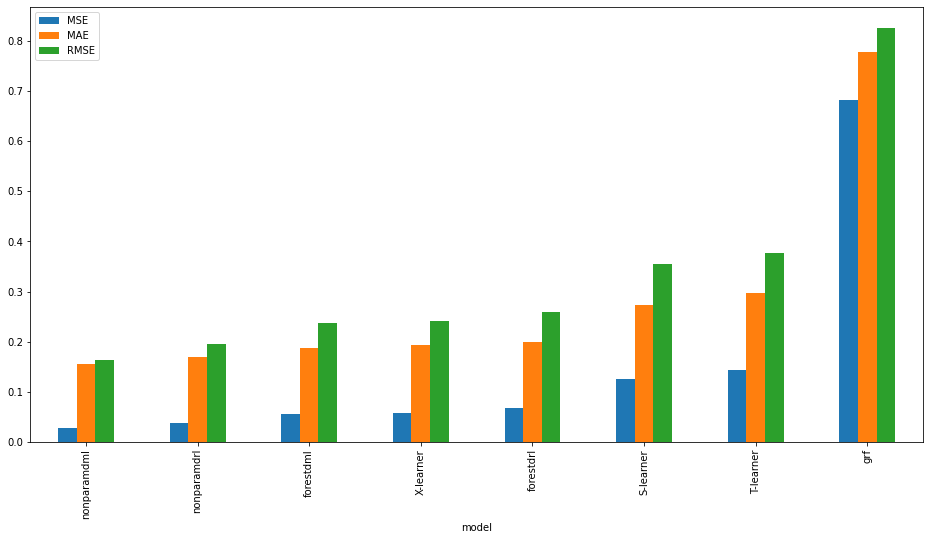

In [211]:
score_df.plot(kind='bar',x='model',y=['MSE', 'MAE', 'RMSE'], figsize=(16,8))

<AxesSubplot:xlabel='model'>

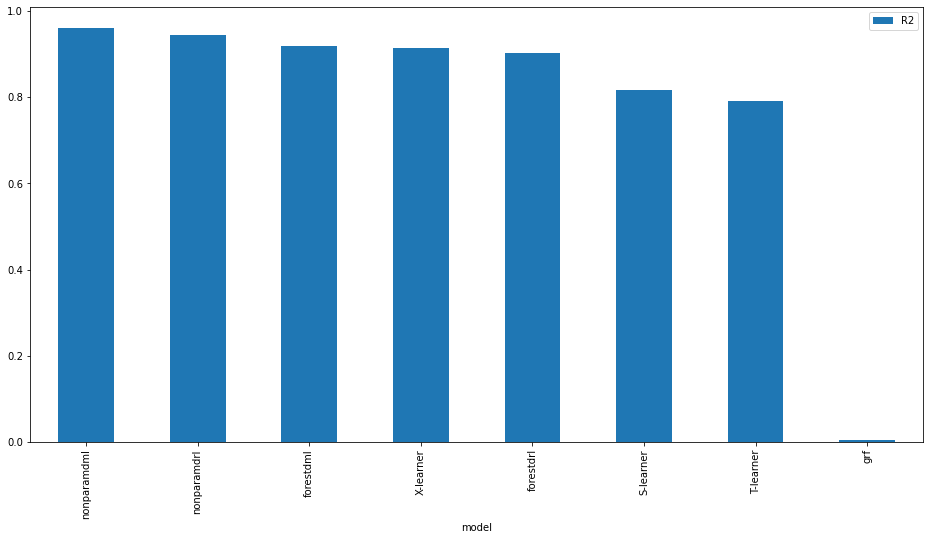

In [212]:
score_df.plot(kind='bar',x='model',y=['R2'], figsize=(16,8))

# IV Models

In [ ]:
# 只利用一个Z
IV = Z.copy(deep=True)
Z = Z.iloc[:,0]

## Train Models

### OrthoIV

In [130]:
model = lambda: LinearRegression()
model_clf = lambda: LogisticRegression()

In [218]:
from econml.iv.dml import OrthoIV

est1 = OrthoIV(projection=False, discrete_treatment=True, discrete_instrument=True)
est1.fit(Y, T, Z=Z, X=X)
pred_orthoiv = est1.effect(X_test)

### Projected OrthoIV

In [220]:
est2 = OrthoIV(projection=True, discrete_treatment=True, discrete_instrument=True)
est2.fit(Y, T, Z=Z, X=X)
pred_pro_orthoiv = est2.effect(X_test)

### DMLIV

In [222]:
from econml.iv.dml import DMLIV, NonParamDMLIV

est3 = DMLIV(discrete_treatment=True, discrete_instrument=True)
est3.fit(Y, T, Z=Z, X=X)
pred_dmliv = est3.effect(X_test)

### Linear DRIV

In [224]:
from econml.iv.dr import LinearDRIV, SparseLinearDRIV, ForestDRIV

est4 = LinearDRIV(discrete_instrument=True, discrete_treatment=True)
est4.fit(Y, T, Z=Z, X=X)
pred_lineardrliv = est4.effect(X_test)

### Linear ITT DRIV

In [225]:
from econml.iv.dr import LinearIntentToTreatDRIV

est5 = LinearIntentToTreatDRIV(model_t_xwz=model_clf())
est5.fit(Y, T, Z=Z, X=X)
pred_linear_itt_drliv = est5.effect(X_test)

## Results Comparation

In [228]:
iv_res = [pred_orthoiv, pred_pro_orthoiv, pred_dmliv, pred_lineardrliv, pred_linear_itt_drliv]
iv_cols = ['orthoIV','PorthoIV','DMLIV','LDRIV','LITTDRIV']
df_res[iv_cols] = np.stack(iv_res, axis=1)

In [233]:
y_list += iv_cols
score_df = pd.DataFrame({'model':[],'MSE':[],'MAE':[],'R2':[],'RMSE':[]})
for col in y_list:
    if col == 'HTE': continue
    mse = mean_squared_error(y_true=df_res['HTE'], y_pred=df_res[col])
    mae = mean_absolute_error(y_true=df_res['HTE'], y_pred=df_res[col])
    r2 = r2_score(y_true=df_res['HTE'], y_pred=df_res[col])
    score_df = score_df.append({'model':col, 'MSE':mse, 'MAE':mae, 'R2':r2, 'RMSE':(mse ** 0.5)},
                               ignore_index=True)
score_df = score_df.sort_values('MSE')
score_df

,model,MSE,MAE,R2,RMSE
3,nonparamdml,0.026863,0.155657,0.960821,0.163900
4,nonparamdrl,0.038031,0.169788,0.944533,0.195014
0,forestdml,0.056183,0.188288,0.918058,0.237029
7,X-learner,0.058644,0.193500,0.914470,0.242164
1,forestdrl,0.067340,0.198467,0.901787,0.259499
9,PorthoIV,0.098408,0.253977,0.856474,0.313700
6,S-learner,0.125646,0.272458,0.816748,0.354466
5,T-learner,0.142592,0.296639,0.792032,0.377614
8,orthoIV,0.244466,0.404729,0.643451,0.494435
2,grf,0.682820,0.777561,0.004122,0.826329
